# Fake News Detection with DistilBERT

In this notebook we fine-tune a pretrained DistilBERT model to classify news articles as **fake** or **real** using the Kaggle fake/real news dataset. Below we set up the libraries, device, and basic configuration.

## Load and label the dataset

Here we load `Fake.csv` and `True.csv`, assign labels (0 = fake, 1 = real), and combine title and body text into a single field that the model will read.

In [31]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

DATA_DIR = "./data"  # Fake.csv / True.csv here
MODEL_NAME = "distilbert-base-uncased"
MAX_LEN = 256
BATCH_SIZE = 32

# Load Kaggle CSVs
fake_path = os.path.join(DATA_DIR, "Fake.csv")
true_path = os.path.join(DATA_DIR, "True.csv")

df_fake = pd.read_csv(fake_path)
df_true = pd.read_csv(true_path)

df_fake["label"] = 0
df_true["label"] = 1

df = pd.concat([df_fake, df_true], ignore_index=True)

df["text_full"] = (df["title"].fillna("") + " " + df["text"].fillna("")).str.strip()
df = df[["text_full", "label"]].rename(columns={"text_full": "text"})

## Train / validation / test split

We split the data into train (70%), validation (15%), and test (15%) sets, stratified by the label, so each split keeps the same fake/real ratio.

In [32]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df["label"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df["label"], random_state=42
)

## Tokenization and dataset wrapper

We initialize the DistilBERT tokenizer and define a `NewsDataset` class that turns each article into padded token IDs and attention masks that the model can process.

In [33]:
# HuggingFace tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class NewsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts = df["text"].tolist()
        self.labels = df["label"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

train_ds = NewsDataset(train_df, tokenizer, MAX_LEN)
val_ds   = NewsDataset(val_df,   tokenizer, MAX_LEN)
test_ds  = NewsDataset(test_df,  tokenizer, MAX_LEN)

## DataLoaders for training, validation, and testing

We wrap the datasets into PyTorch `DataLoader`s so Lightning can iterate over mini-batches efficiently during training, validation, and testing.

In [34]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)

## Neural network: DistilBERT classifier

Here we define the neural network: a pretrained DistilBERT encoder plus a small classification head on top. We also set up the training, validation, and test steps using cross-entropy loss and accuracy.

In [35]:
import torch
from torch import nn
import torchmetrics
from transformers import AutoModelForSequenceClassification
from lightning.pytorch import LightningModule

NUM_CLASSES = 2

class DistilBertClassifier(LightningModule):
    def __init__(self, model_name, lr=2e-5):
        super().__init__()
        self.save_hyperparameters()
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=NUM_CLASSES,
        )
        self.accuracy = torchmetrics.classification.Accuracy(
            task="multiclass", num_classes=NUM_CLASSES
        )

    def forward(self, input_ids, attention_mask):
        return self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

    def _shared_step(self, batch, stage: str):
        out = self(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
        )
        logits = out.logits
        loss = nn.functional.cross_entropy(logits, batch["labels"])
        preds = logits.argmax(dim=-1)

        self.accuracy(preds, batch["labels"])
        self.log(f"{stage}_loss", loss, prog_bar=True)
        self.log(f"{stage}_acc", self.accuracy, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        if batch_idx == 0:
            print("Model device:", next(self.parameters()).device)
            print("Batch device:", batch["input_ids"].device)
        return self._shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self._shared_step(batch, "test")

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

## Train and test the model on GPU

We create a Lightning `Trainer` that runs on the RTX 4070 GPU, fine-tune DistilBERT for a few epochs on the training set, monitor validation performance, and finally evaluate on the held-out test set.

In [36]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint

model = DistilBertClassifier(MODEL_NAME)
model.train()

checkpoint_cb = ModelCheckpoint(
    dirpath="checkpoints",
    filename="fake-news-{epoch:02d}-{val_loss:.3f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
)

trainer = Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=3,
    callbacks=[checkpoint_cb],
    log_every_n_steps=10,
)

trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

print("Best checkpoint:", checkpoint_cb.best_model_path)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                                | Params | Mode  | FLOPs
---------------------------------------------------------------------------------
0 | model    | DistilBertForSequenceClassification | 67.0 M | train | 0    
1 | accuracy | MulticlassAccuracy                  | 0      | train | 0    
---------------------------------------------------------------------------------
67.0 M    Trainable params
0         Non-trainable params
67.0 M    Total params
267.820   Total estimated model params size (MB)
97

Sanity Checking: |                                                                                     | 0/? […

C:\Users\Mridul Sharma\OneDrive\Desktop\Assignments\2025 Fall\Machine Learning\fakeNEWS\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\Mridul Sharma\OneDrive\Desktop\Assignments\2025 Fall\Machine Learning\fakeNEWS\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |                                                                                            | 0/? […

Model device: cuda:0
Batch device: cuda:0


Validation: |                                                                                          | 0/? […

Model device: cuda:0
Batch device: cuda:0


Validation: |                                                                                          | 0/? […

Model device: cuda:0
Batch device: cuda:0


Validation: |                                                                                          | 0/? […

`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Mridul Sharma\OneDrive\Desktop\Assignments\2025 Fall\Machine Learning\fakeNEWS\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |                                                                                             | 0/? […

──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9998515248298645
        test_loss          0.0003762487613130361
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Best checkpoint: C:\Users\Mridul Sharma\OneDrive\Desktop\Assignments\2025 Fall\Machine Learning\fakeNEWS\checkpoints\fake-news-epoch=02-val_loss=0.000.ckpt


## Detailed evaluation on the test set

We collect predictions on the test set and print a classification report (precision/recall/F1 per class) and a confusion matrix to see how often fake and real articles are correctly or incorrectly classified.

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def get_predictions_and_labels(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(model.device)
            attention_mask = batch["attention_mask"].to(model.device)
            labels = batch["labels"].cpu().numpy()

            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            ).logits

            preds = torch.argmax(logits, dim=-1).cpu().numpy()

            all_labels.extend(labels)
            all_preds.extend(preds)

    return np.array(all_labels), np.array(all_preds)


y_true, y_pred = get_predictions_and_labels(model, test_loader)

## Detailed evaluation on the test set

We collect predictions on the test set and print a classification report (precision/recall/F1 per class) and a confusion matrix to see how often fake and real articles are correctly or incorrectly classified.

In [38]:
print(classification_report(
    y_true,
    y_pred,
    target_names=["fake", "real"],
    digits=4
))

print("Confusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

        fake     0.9997    1.0000    0.9999      3523
        real     1.0000    0.9997    0.9998      3212

    accuracy                         0.9999      6735
   macro avg     0.9999    0.9998    0.9999      6735
weighted avg     0.9999    0.9999    0.9999      6735

Confusion matrix (rows=true, cols=pred):
[[3523    0]
 [   1 3211]]


## Training curve from Lightning logs

Here we load the `metrics.csv` file produced by Lightning for this run and plot the validation accuracy over epochs.

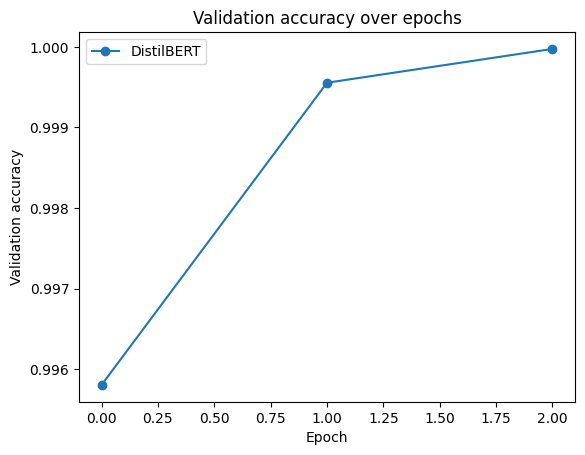

In [39]:
import matplotlib.pyplot as plt

# Path to the Lightning metrics file for this run
metrics_path = "lightning_logs/version_4/metrics.csv"  # root\lightning_logs\version_0\metrics.csv

# Load metrics
metrics = pd.read_csv(metrics_path)

# Extract validation accuracy values (one per epoch; drop NaNs)
val_acc = metrics["val_acc"].dropna().reset_index(drop=True)

# Plot
fig = plt.figure()
ax = fig.gca()
ax.set_xlabel("Epoch")
ax.set_ylabel("Validation accuracy")

val_acc.plot(ax=ax, marker="o")
ax.legend(["DistilBERT"])
ax.set_title("Validation accuracy over epochs")

plt.show()

## Exporting the Model

In [42]:
from pathlib import Path

BEST_CKPT = checkpoint_cb.best_model_path
EXPORT_DIR = Path("export/fake_news_model")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

lit_model = DistilBertClassifier.load_from_checkpoint(BEST_CKPT)

hf_model = lit_model.model
tokenizer = AutoTokenizer.from_pretrained(lit_model.hparams.model_name)

hf_model.save_pretrained(EXPORT_DIR)
tokenizer.save_pretrained(EXPORT_DIR)

print("Exported to:", EXPORT_DIR.resolve())

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Exported to: C:\Users\Mridul Sharma\OneDrive\Desktop\Assignments\2025 Fall\Machine Learning\fakeNEWS\export\fake_news_model
